In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c chembl chembl_structure_pipeline
import chembl_structure_pipeline
from chembl_structure_pipeline import standardizer

In [ ]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 4.87 ms (started: 2021-11-30 14:58:28 +00:00)


In [ ]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, MaxPooling
import dgl.function as fn
import dgllife
from dgllife import utils

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


time: 8.84 s (started: 2021-11-30 14:58:29 +00:00)


## Create Dataset

In [ ]:
def create_dataset(df, name, bonds):
    print(f"Creating Dataset and Saving to {drive_path}/data/{name}.pkl")
    data = df.sample(frac=1)
    data = data.reset_index(drop=True)
    data['mol'] = data['smiles'].apply(lambda x: create_dgl_features(x, bonds))
    data.to_pickle(f"{drive_path}/data/{name}.pkl")
    return data

def featurize_atoms(mol):
  feats = []
  
  atom_features = utils.ConcatFeaturizer([
    utils.atom_type_one_hot,
    utils.atomic_number_one_hot,
    utils.atom_degree_one_hot,
    utils.atom_explicit_valence_one_hot,
    utils.atom_formal_charge_one_hot,
    utils.atom_num_radical_electrons_one_hot,
    utils.atom_hybridization_one_hot,
    utils.atom_is_aromatic_one_hot
  ])

  for atom in mol.GetAtoms():
    feats.append(atom_features(atom))
  return {'feats': torch.tensor(feats).float()}

def featurize_bonds(mol):
  feats = []
  
  bond_features = utils.ConcatFeaturizer([
    utils.bond_type_one_hot,
    utils.bond_is_conjugated_one_hot,
    utils.bond_is_in_ring_one_hot,
    utils.bond_stereo_one_hot,
    utils.bond_direction_one_hot,
  ])

  for bond in mol.GetBonds():
    feats.append(bond_features(bond))
    feats.append(bond_features(bond))
  return {'edge_feats': torch.tensor(feats).float()}

def create_dgl_features(smiles, bonds):
    mol = Chem.MolFromSmiles(smiles)
    mol = standardizer.standardize_mol(mol)
    
    if bonds:
        dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    edge_featurizer=featurize_bonds,
                                    canonical_atom_order=True)
    else:
      dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    canonical_atom_order=True)
    
    dgl_graph = dgl.add_self_loop(dgl_graph)
    
    return dgl_graph

def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_tasks, train_dfs, test_tasks, test_dfs

time: 136 ms (started: 2021-11-30 14:58:37 +00:00)


## Graph Embedding

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels=128):
      super(GCN, self).__init__()
      self.conv1 = GraphConv(in_channels, 64)
      self.conv2 = GraphConv(64, 128)
      self.conv3 = GraphConv(128, 64)
      self.sum_pool = SumPooling()
      self.dense = nn.Linear(64, out_channels)

      self.dense2 = nn.Linear(128, 1)

    def forward(self, graph, in_feat):
        h = self.conv1(graph, in_feat)
        h = F.relu(h)
        graph.ndata['h'] = h       
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))
      
        h = self.conv2(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        h = self.conv3(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        output = self.sum_pool(graph, graph.ndata['h'])
        output = torch.tanh(output)
        output = self.dense(output)
        output = torch.tanh(output)

        output = self.dense2(output) # FOR BENCHMARK

        return output

time: 21.2 ms (started: 2021-11-30 14:58:38 +00:00)


## Training Loop

In [ ]:
def train(train_X, train_y, episodes, lr):
  start_time = time.time()

  node_feat_size = 177
  embedding_size = 128

  encoder = GCN(node_feat_size, embedding_size)

  loss_fn = nn.BCEWithLogitsLoss()
  sig = nn.Sigmoid()

  if torch.cuda.is_available(): 
    encoder = encoder.cuda()
    sig = sig.cuda()
    loss_fn = loss_fn.cuda()

  encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = lr)
  encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, patience=50, verbose=False)

  episode_num = 1
  losses = []

  running_loss = 0.0
  running_acc = 0.0
  running_roc = []
  running_prc = []

  encoder.train()

  # for task in shuffled_train_tasks:
  pbar = trange(episodes, desc=f"Training")
  # while episode_num < episodes and not early_stop:
  for episode in pbar:
    episode_loss = []
    episode_acc = []
    episode_roc = []
    episode_prc = []

    # CREATE EMBEDDINGS
    dataloader = GraphDataLoader(train_X, batch_size=len(train_X), shuffle=False, pin_memory=True)
    for batched_graph in dataloader:
      batched_graph = batched_graph.to(device)
      
      if with_bonds:
        pred = encoder.forward(batched_graph, (batched_graph.ndata['feats'].float(), batched_graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
      else:
        pred = encoder.forward(batched_graph, batched_graph.ndata['feats'].float()) # FOR NODES ONLY

    labels = torch.FloatTensor(train_y)
    labels = labels.to(device)
    loss = loss_fn(pred.squeeze(), labels)
      
    pred = sig(pred)
    _, y_hat = pred.max(1)

    episode_loss.append(loss.item())
    encoder.zero_grad()
    loss.backward()
    encoder_optimizer.step()

    labels = labels.detach().cpu()
    y_hat = y_hat.detach().cpu()
    
    roc = roc_auc_score(labels, y_hat)
    prc = average_precision_score(labels, y_hat)
    acc = accuracy_score(labels, y_hat)

    # EVALUATE TRAINING LOOP ON TASK
    running_roc.append(roc)
    running_prc.append(prc)

    losses.append(statistics.mean(episode_loss))
    pbar.set_description(f"Episode {episode_num} - Loss {statistics.mean(episode_loss):.6f} - LR {encoder_optimizer.param_groups[0]['lr']}")
    pbar.refresh()

    if encoder_optimizer.param_groups[0]['lr'] < 0.000001:
      break # EARLY STOP
    elif episode_num < episodes:
      episode_num += 1

    encoder_scheduler.step(loss)

  end_time = time.time()
  train_info = {
      "losses": losses,
      "duration": str(timedelta(seconds=(end_time - start_time))),
      "episodes": episode_num,
      "train_roc": statistics.mean(running_roc),
      "train_prc": statistics.mean(running_prc),
  }

  return encoder, losses, train_info

time: 78.1 ms (started: 2021-11-30 14:58:38 +00:00)


## Testing Loop

In [ ]:
def test(encoder, test_X, test_y, task, rounds, k_pos, k_neg):
  
  test_info = {}

  running_loss = []
  running_acc = []
  running_roc = [0]
  running_prc = [0]

  running_preds = []
  running_targets = []
  running_actuals = []

  encoder.eval()

  with torch.no_grad():
    # CREATE EMBEDDINGS
    dataloader = GraphDataLoader(test_X, batch_size=len(test_X), shuffle=False, pin_memory=True)
    for batched_graph in dataloader:
      batched_graph = batched_graph.to(device)

      if with_bonds:
        pred = encoder.forward(batched_graph, (batched_graph.ndata['feats'].float(), batched_graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
      else:
        pred = encoder.forward(batched_graph, batched_graph.ndata['feats'].float()) # FOR NODES ONLY

    # PRED
    pred = nn.Sigmoid()(pred)

    # _, y_hat_actual = pred.max(1)
    y_hat_actual = np.round(pred.detach().cpu())
    y_hat = pred
    # _, y_hat = pred.max(1)

    y_hat = y_hat.detach().cpu()
    labels = test_y
    y_hat_actual = y_hat_actual.detach().cpu()
    
    roc = roc_auc_score(labels, y_hat)
    prc = average_precision_score(labels, y_hat)
    acc = accuracy_score(labels, y_hat_actual)

    print(f'Test {task}')
    print(f"Acc: {acc}")
    print(f"ROC: {roc}")
    print(f"PRC: {prc}")

  return labels, y_hat, roc, prc

time: 23 ms (started: 2021-11-30 14:58:38 +00:00)


## Initiate Training and Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 1min 22s (started: 2021-11-30 14:58:38 +00:00)


In [ ]:
# PATHS
drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "GCNBenchmark"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS
dataset = 'dude-gpcr'
with_bonds = False 
test_rounds = 20
episodes = 2000
lr = 0.001

time: 2.48 ms (started: 2021-11-30 15:00:00 +00:00)


In [ ]:
#FOR DETERMINISTIC REPRODUCABILITY
randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

# LOAD DATASET
train_tasks, train_dfs, test_tasks, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='graph', create_new=False)

train_data = pd.DataFrame(columns=['y', 'mol'])
for key in train_dfs.keys():
  train_data = train_data.append(train_dfs[key], ignore_index=True)
# train_data = train_data.sample(frac=1).reset_index(drop=True)
# train_data = train_data.values.tolist()

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
Feature Length 177
Edge Features:  False
adrb2 15231
cxcr4 3446
time: 50.4 s (started: 2021-11-30 15:00:00 +00:00)


### Run


RUNNING 10+/10-
ROUND  0


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.46it/s]


Test adrb2
Acc: 0.8744987180330024
ROC: 0.9275532104359165
PRC: 0.43481934662465266
ROUND  1


Episode 2000 - Loss 0.000005 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 54.04it/s]


Test adrb2
Acc: 0.8985602524488857
ROC: 0.9298219929425047
PRC: 0.32621213534297555
ROUND  2


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:36<00:00, 54.34it/s]


Test adrb2
Acc: 0.697784498060614
ROC: 0.9295993709229985
PRC: 0.27132669671470516
ROUND  3


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:36<00:00, 54.24it/s]


Test adrb2
Acc: 0.5367168496482808
ROC: 0.9236940765940491
PRC: 0.16520538115297811
ROUND  4


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:36<00:00, 54.12it/s]


Test adrb2
Acc: 0.8344619025705082
ROC: 0.9224315456156291
PRC: 0.2405330532756102
ROUND  5


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:36<00:00, 54.20it/s]


Test adrb2
Acc: 0.8837683255538755
ROC: 0.9594948668644859
PRC: 0.5133364179847527
ROUND  6


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.56it/s]


Test adrb2
Acc: 0.7772664519098021
ROC: 0.9262610971416843
PRC: 0.3859554057359287
ROUND  7


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.45it/s]


Test adrb2
Acc: 0.9272237196765498
ROC: 0.9383213243217954
PRC: 0.4317693000889907
ROUND  8


Episode 2000 - Loss 0.000005 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.17it/s]


Test adrb2
Acc: 0.9547695746499244
ROC: 0.94584398648873
PRC: 0.2913252865705932
ROUND  9


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.77it/s]


Test adrb2
Acc: 0.910065084478338
ROC: 0.9272869695936053
PRC: 0.28541081602702
ROUND  10


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.16it/s]


Test adrb2
Acc: 0.8292682926829268
ROC: 0.9057791166961986
PRC: 0.25252566324555753
ROUND  11


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.21it/s]


Test adrb2
Acc: 0.7517585957530735
ROC: 0.9215206819629376
PRC: 0.24987785839891563
ROUND  12


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.48it/s]


Test adrb2
Acc: 0.7127079087502465
ROC: 0.9060151715019666
PRC: 0.27130223319039626
ROUND  13


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 53.66it/s]


Test adrb2
Acc: 0.9597659588455723
ROC: 0.9560609033473296
PRC: 0.40139460331568705
ROUND  14


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.89it/s]


Test adrb2
Acc: 0.8938268358424825
ROC: 0.8604772714237848
PRC: 0.23748623520503317
ROUND  15


Episode 2000 - Loss 0.000004 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.72it/s]


Test adrb2
Acc: 0.8125041088685819
ROC: 0.8526966695745882
PRC: 0.23035918860118149
ROUND  16


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 52.60it/s]


Test adrb2
Acc: 0.9228847544540135
ROC: 0.8964483109403252
PRC: 0.37721164091352055
ROUND  17


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.92it/s]


Test adrb2
Acc: 0.6744461245151535
ROC: 0.892421040874912
PRC: 0.18872069346314793
ROUND  18


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.80it/s]


Test adrb2
Acc: 0.9370192623759122
ROC: 0.8061232375127914
PRC: 0.20803592164224094
ROUND  19


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.8938925777397936
ROC: 0.9613042178948861
PRC: 0.45265638504988104
ROUND  0


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 52.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9030939871570345
ROC: 0.9799813506085591
PRC: 0.5267180277756405
ROUND  1


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:37<00:00, 52.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.946584938704028
ROC: 0.9762956419316843
PRC: 0.5469691291293067
ROUND  2


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 52.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.848219497956801
ROC: 0.9513987043580683
PRC: 0.6748467398590706
ROUND  3


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 52.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8779918272037361
ROC: 0.9713829996073813
PRC: 0.8208260011365947
ROUND  4


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9515469935785172
ROC: 0.9574204946996467
PRC: 0.8094507592243297
ROUND  5


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9810274372446001
ROC: 0.9306635257165292
PRC: 0.7374959867543064
ROUND  6


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.780502043199066
ROC: 0.9899293286219081
PRC: 0.58469080147532
ROUND  7


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9474605954465849
ROC: 0.9934923439340401
PRC: 0.740809305244997
ROUND  8


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.7775831873905429
ROC: 0.9380005889281506
PRC: 0.7815910411329824
ROUND  9


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 52.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9801517805020432
ROC: 0.9345406360424028
PRC: 0.8296138510270336
ROUND  10


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9769410391126678
ROC: 0.9584805653710247
PRC: 0.8023521697316012
ROUND  11


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9897840046701692
ROC: 0.9636435021594033
PRC: 0.8514835445812851
ROUND  12


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 50.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9906596614127262
ROC: 0.9431389870435807
PRC: 0.8389241331504266
ROUND  13


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8604786923525978
ROC: 0.9859638790734198
PRC: 0.6467346713495303
ROUND  14


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8718622300058377
ROC: 0.9756919905771495
PRC: 0.6824559118655062
ROUND  15


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.968476357267951
ROC: 0.9837063211621516
PRC: 0.7205323525951163
ROUND  16


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8917104495037945
ROC: 0.965086376128779
PRC: 0.34689512165319075
ROUND  17


Episode 2000 - Loss 0.000006 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8563922942206655
ROC: 0.9815812720848056
PRC: 0.6601617566426087
ROUND  18


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.7425569176882661
ROC: 0.9841627404789949
PRC: 0.534894773068182
ROUND  19


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9830706363105662
ROC: 0.9374361994503337
PRC: 0.8117935555721405

RUNNING 5+/10-
ROUND  0


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7762223974763407
ROC: 0.9312116632327155
PRC: 0.3133539445501939
ROUND  1


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7875920084121977
ROC: 0.8094297378193132
PRC: 0.10544591478071133
ROUND  2


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.975617770767613
ROC: 0.8790701175414879
PRC: 0.20213135933638657
ROUND  3


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9528128286014721
ROC: 0.859040687892223
PRC: 0.13022513769061245
ROUND  4


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9485410094637224
ROC: 0.9094121744880066
PRC: 0.23871249504052647
ROUND  5


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9649710830704522
ROC: 0.8480807263839609
PRC: 0.18213856083485463
ROUND  6


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:38<00:00, 51.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9487381703470031
ROC: 0.8534424129360576
PRC: 0.2471428394789643
ROUND  7


Episode 2000 - Loss 0.000005 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9362513144058885
ROC: 0.8760354985919816
PRC: 0.20979435170702124
ROUND  8


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 50.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.906611461619348
ROC: 0.9308438664124166
PRC: 0.24914600734343226
ROUND  9


Episode 2000 - Loss 0.000003 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 51.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.8689537329127235
ROC: 0.8278364042104767
PRC: 0.11568277344705928
ROUND  10


Episode 2000 - Loss 0.000007 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9529442691903259
ROC: 0.908816349542763
PRC: 0.35493074112922285
ROUND  11


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:39<00:00, 50.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9795609884332281
ROC: 0.899789240024323
PRC: 0.3645006796262379
ROUND  12


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9716745531019979
ROC: 0.9001756333130642
PRC: 0.3437304764061009
ROUND  13


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9594505783385909
ROC: 0.8093011860414319
PRC: 0.10341849786430794
ROUND  14


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.962605152471083
ROC: 0.9610247539657708
PRC: 0.4572678880214538
ROUND  15


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9263275499474237
ROC: 0.8140970086252192
PRC: 0.09616988256089704
ROUND  16


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9179153522607781
ROC: 0.8397009510765289
PRC: 0.2429853715593405
ROUND  17


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.8253154574132492
ROC: 0.894065512701683
PRC: 0.23884221813200712
ROUND  18


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9534700315457413
ROC: 0.883524414506426
PRC: 0.2807091296621447
ROUND  19


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7393533123028391
ROC: 0.8559319782509873
PRC: 0.11908652131116283
ROUND  0


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9399591955698047
ROC: 0.9726064277301026
PRC: 0.7691487860417272
ROUND  1


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9638589332556106
ROC: 0.9495078243311459
PRC: 0.39405677095719516
ROUND  2


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9865928300786942
ROC: 0.9423523472993437
PRC: 0.8016065165543428
ROUND  3


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.7537161177499271
ROC: 0.8175416456335185
PRC: 0.2556162714606475
ROUND  4


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 45.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9915476537452638
ROC: 0.9694430422345617
PRC: 0.7868834193910641
ROUND  5


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9830953074905275
ROC: 0.7426972909305065
PRC: 0.3648730156965934
ROUND  6


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9122704750801516
ROC: 0.9422429749284873
PRC: 0.6065286125182969
ROUND  7


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.987467210725736
ROC: 0.9496634696281337
PRC: 0.87448090308895
ROUND  8


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9822209268434858
ROC: 0.9423355207807504
PRC: 0.7723819770672173
ROUND  9


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9693966773535413
ROC: 0.9553634528016153
PRC: 0.7012176347552931
ROUND  10


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 44.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9204313611192072
ROC: 0.9675668854114083
PRC: 0.4257997889488299
ROUND  11


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:45<00:00, 43.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.938501894491402
ROC: 0.9544127545010936
PRC: 0.5892131932056074
ROUND  12


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9830953074905275
ROC: 0.9435638566380615
PRC: 0.7918443270910304
ROUND  13


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 44.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9717283590789857
ROC: 0.9606848393067474
PRC: 0.6387683810675868
ROUND  14


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9236374234916934
ROC: 0.9395423186942622
PRC: 0.7114951075099446
ROUND  15


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 45.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9658991547653746
ROC: 0.9415741208144035
PRC: 0.7626500518277588
ROUND  16


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8641795394928592
ROC: 0.9633181894665994
PRC: 0.4080924808652345
ROUND  17


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 44.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9224715826289711
ROC: 0.8051110550227158
PRC: 0.37812829154607225
ROUND  18


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:44<00:00, 44.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9886330515884582
ROC: 0.936648157496214
PRC: 0.6659337843930697
ROUND  19


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9965024774118333
ROC: 0.9457891637220258
PRC: 0.8191973967631342

RUNNING 1+/10-
ROUND  0


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9850854139290407
ROC: 0.8052239173942047
PRC: 0.11904824847669873
ROUND  1


Episode 2000 - Loss 0.000033 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9835085413929041
ROC: 0.8186016764799722
PRC: 0.15943197268950948
ROUND  2


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9850854139290407
ROC: 0.7980833599211068
PRC: 0.22434854247735223
ROUND  3


Episode 2000 - Loss 0.000030 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9789093298291721
ROC: 0.5907599269077937
PRC: 0.020160573826390887
ROUND  4


Episode 2000 - Loss 0.000030 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9848883048620236
ROC: 0.8041270992255707
PRC: 0.19523282494832644
ROUND  5


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9832457293035479
ROC: 0.8439359573048699
PRC: 0.1217815135122013
ROUND  6


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9837056504599212
ROC: 0.778961916640079
PRC: 0.11444235524392987
ROUND  7


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9831143232588699
ROC: 0.7839942570409258
PRC: 0.12321039829216586
ROUND  8


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9481603153745072
ROC: 0.6517736461989152
PRC: 0.02228397196963255
ROUND  9


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9819973718791064
ROC: 0.8529770571685471
PRC: 0.08381665859508981
ROUND  10


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.981011826544021
ROC: 0.7216705339791745
PRC: 0.10913934787533093
ROUND  11


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9850197109067017
ROC: 0.7001509702120254
PRC: 0.056451348473441944
ROUND  12


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9842969776609723
ROC: 0.7090361690402297
PRC: 0.041373609400014694
ROUND  13


Episode 2000 - Loss 0.000023 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9597897503285151
ROC: 0.62856861095803
PRC: 0.03293430669641276
ROUND  14


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9831143232588699
ROC: 0.6691646604983033
PRC: 0.03874841717488868
ROUND  15


Episode 2000 - Loss 0.000038 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9850197109067017
ROC: 0.7750495982829133
PRC: 0.12561608651660985
ROUND  16


Episode 2000 - Loss 0.000032 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9798291721419186
ROC: 0.7478365287002929
PRC: 0.0767430288040168
ROUND  17


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9825229960578187
ROC: 0.7270961800620703
PRC: 0.06192145900464151
ROUND  18


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9852825229960578
ROC: 0.7661462714273284
PRC: 0.11709480417904963
ROUND  19


Episode 2000 - Loss 0.000019 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9844940867279894
ROC: 0.7812791136119732
PRC: 0.1403134503997038
ROUND  0


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.975254730713246
ROC: 0.9149527347407206
PRC: 0.46846488598533387
ROUND  1


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 49.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9898107714701602
ROC: 0.8747017607441635
PRC: 0.3331175156087948
ROUND  2


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9880640465793304
ROC: 0.5505496662740479
PRC: 0.05200569764026083
ROUND  3


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.988646288209607
ROC: 0.8875902268128416
PRC: 0.1578288202499198
ROUND  4


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9901018922852984
ROC: 0.9502129201775844
PRC: 0.5193997750773824
ROUND  5


Episode 2000 - Loss 0.000024 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9921397379912664
ROC: 0.6678860499531878
PRC: 0.36155745005855144
ROUND  6


Episode 2000 - Loss 0.000020 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.988646288209607
ROC: 0.888352813264474
PRC: 0.16172292836409893
ROUND  7


Episode 2000 - Loss 0.000026 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.990684133915575
ROC: 0.7526841533025279
PRC: 0.3714244684032853
ROUND  8


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9930131004366812
ROC: 0.7803864274712331
PRC: 0.48985715190608203
ROUND  9


Episode 2000 - Loss 0.000032 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.992721979621543
ROC: 0.9102262088127813
PRC: 0.5927646066331088
ROUND  10


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9842794759825327
ROC: 0.8403174171725409
PRC: 0.2698442482214458
ROUND  11


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9915574963609898
ROC: 0.9179879798254357
PRC: 0.4593066640573445
ROUND  12


Episode 2000 - Loss 0.000019 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9895196506550218
ROC: 0.8908293316420524
PRC: 0.23166164954956875
ROUND  13


Episode 2000 - Loss 0.000030 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.990684133915575
ROC: 0.6697849657213615
PRC: 0.345961269836888
ROUND  14


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9912663755458515
ROC: 0.7821267856603545
PRC: 0.35763411294548
ROUND  15


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9933042212518195
ROC: 0.9451617287306333
PRC: 0.7086633518607602
ROUND  16


Episode 2000 - Loss 0.000034 - LR 0.001: 100%|██████████| 2000/2000 [00:40<00:00, 48.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9898107714701602
ROC: 0.8199163420011476
PRC: 0.4096042589103012
ROUND  17


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9915574963609898
ROC: 0.7366622874573403
PRC: 0.3635787959811539
ROUND  18


Episode 2000 - Loss 0.000037 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9834061135371179
ROC: 0.9306990124127934
PRC: 0.42827147894278067
ROUND  19


Episode 2000 - Loss 0.000028 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.988646288209607
ROC: 0.840879919060131
PRC: 0.13482796546827303

RUNNING 1+/5-
ROUND  0


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9808866995073892
ROC: 0.6622411818432231
PRC: 0.028818697616378244
ROUND  1


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9843021346469623
ROC: 0.7475674500195717
PRC: 0.17147390996482104
ROUND  2


Episode 2000 - Loss 0.000024 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9642036124794745
ROC: 0.7586737608188237
PRC: 0.06864392263203739
ROUND  3


Episode 2000 - Loss 0.000029 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9733333333333334
ROC: 0.7352146367629789
PRC: 0.13681568253753956
ROUND  4


Episode 2000 - Loss 0.000032 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9750410509031199
ROC: 0.6286714412050394
PRC: 0.03637990772179962
ROUND  5


Episode 2000 - Loss 0.000024 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9841050903119869
ROC: 0.6990012612899952
PRC: 0.07841452978650339
ROUND  6


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9848932676518883
ROC: 0.6471057019006335
PRC: 0.06535114555311328
ROUND  7


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9606568144499179
ROC: 0.8577547588326544
PRC: 0.06947740291154075
ROUND  8


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9851559934318554
ROC: 0.7893474636473028
PRC: 0.2492029554076888
ROUND  9


Episode 2000 - Loss 0.000020 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9823316912972085
ROC: 0.8123270075532424
PRC: 0.16210337993595242
ROUND  10


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9835796387520526
ROC: 0.6507986720211085
PRC: 0.07632426561543376
ROUND  11


Episode 2000 - Loss 0.000036 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9772742200328407
ROC: 0.8191175319309336
PRC: 0.06468858184170881
ROUND  12


Episode 2000 - Loss 0.000029 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9764203612479475
ROC: 0.691259405309016
PRC: 0.04487919451715598
ROUND  13


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9846305418719212
ROC: 0.8365531988923844
PRC: 0.14896764284806427
ROUND  14


Episode 2000 - Loss 0.000049 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9779967159277504
ROC: 0.7504682720327065
PRC: 0.04551262579776712
ROUND  15


Episode 2000 - Loss 0.000009 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9837110016420362
ROC: 0.6712259158850051
PRC: 0.08254172996945014
ROUND  16


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9849589490968801
ROC: 0.8440842599707149
PRC: 0.16867072260630747
ROUND  17


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9798357963875205
ROC: 0.8975635356713106
PRC: 0.11201028983578377
ROUND  18


Episode 2000 - Loss 0.000026 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9740558292282431
ROC: 0.6919790654855966
PRC: 0.03639516875948548
ROUND  19


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 48.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9811494252873563
ROC: 0.6942453281528624
PRC: 0.05288460908434691
ROUND  0


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:41<00:00, 47.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9912790697674418
ROC: 0.6706850926198178
PRC: 0.3523543470241397
ROUND  1


Episode 2000 - Loss 0.000027 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9895348837209302
ROC: 0.7929643619146707
PRC: 0.19388696866807054
ROUND  2


Episode 2000 - Loss 0.000026 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9854651162790697
ROC: 0.7008195176381005
PRC: 0.4535405384167563
ROUND  3


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9912790697674418
ROC: 0.7207834799719539
PRC: 0.3564700171671024
ROUND  4


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9875
ROC: 0.7560860682001522
PRC: 0.31936929112616463
ROUND  5


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9886627906976744
ROC: 0.6744848800126659
PRC: 0.2780794498065208
ROUND  6


Episode 2000 - Loss 0.000019 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9889534883720931
ROC: 0.8970513951401925
PRC: 0.4659524780292896
ROUND  7


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9898255813953488
ROC: 0.6861895822495646
PRC: 0.4006906604590673
ROUND  8


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9895348837209302
ROC: 0.9133663552951997
PRC: 0.27304989965272664
ROUND  9


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9883720930232558
ROC: 0.7604136038420072
PRC: 0.31624469115134074
ROUND  10


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9883720930232558
ROC: 0.8652130972036882
PRC: 0.05466268556609533
ROUND  11


Episode 2000 - Loss 0.000027 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9901162790697674
ROC: 0.8574099623790892
PRC: 0.4311868259662061
ROUND  12


Episode 2000 - Loss 0.000026 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9869186046511628
ROC: 0.9387661245938224
PRC: 0.36230584041709935
ROUND  13


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9901162790697674
ROC: 0.6981204623074662
PRC: 0.33262388937756787
ROUND  14


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9918604651162791
ROC: 0.7531193691146647
PRC: 0.3301246479985975
ROUND  15


Episode 2000 - Loss 0.000026 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9904069767441861
ROC: 0.865446814285391
PRC: 0.35286773833732743
ROUND  16


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9895348837209302
ROC: 0.9430861209749772
PRC: 0.615433244180616
ROUND  17


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9781976744186046
ROC: 0.700627266490248
PRC: 0.4000937847705176
ROUND  18


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9787790697674419
ROC: 0.7177526971705154
PRC: 0.30520867585738753
ROUND  19


Episode 2000 - Loss 0.000022 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9909883720930233
ROC: 0.7096517615482625
PRC: 0.3404169374959516

RUNNING 1+/1-
ROUND  0


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7821262065795521
ROC: 0.6048438011809483
PRC: 0.020582766700601635
ROUND  1


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.22792041499770174
ROC: 0.6079690819967707
PRC: 0.028796542680770813
ROUND  2


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9357147547442379
ROC: 0.8569266936636356
PRC: 0.06736706978334624
ROUND  3


Episode 2000 - Loss 0.000014 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.29516054895265614
ROC: 0.7393710305324702
PRC: 0.03870409836576619
ROUND  4


Episode 2000 - Loss 0.000008 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7704379801694137
ROC: 0.8075909408453317
PRC: 0.05706632029859387
ROUND  5


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9495698995337842
ROC: 0.7190922873119077
PRC: 0.030722340071562052
ROUND  6


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.08332786131722372
ROC: 0.7449738678230723
PRC: 0.04118218343628718
ROUND  7


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.15037100269223191
ROC: 0.7711092333691811
PRC: 0.05919127143918307
ROUND  8


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.12857049051152405
ROC: 0.685905147299675
PRC: 0.06457024687952628
ROUND  9


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.7727362269354521
ROC: 0.687491340002377
PRC: 0.05138804482567555
ROUND  10


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.05312233239214656
ROC: 0.8250494960533601
PRC: 0.12897319162082285
ROUND  11


Episode 2000 - Loss 0.000012 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.6444940573905049
ROC: 0.7421580279264994
PRC: 0.13050961337031303
ROUND  12


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.3029089237638716
ROC: 0.7576364511257273
PRC: 0.04004773901694784
ROUND  13


Episode 2000 - Loss 0.000020 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.20506927572394773
ROC: 0.8419156929302534
PRC: 0.09357669838470067
ROUND  14


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.05377897432530041
ROC: 0.730987283210185
PRC: 0.04007884410912067
ROUND  15


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.13776347757567797
ROC: 0.8101527058325628
PRC: 0.10465244107813737
ROUND  16


Episode 2000 - Loss 0.000010 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.19758355768599384
ROC: 0.7136067042150637
PRC: 0.04761313019449541
ROUND  17


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.32444677917131787
ROC: 0.5691517115633795
PRC: 0.03113537969853668
ROUND  18


Episode 2000 - Loss 0.000021 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.9409678902094688
ROC: 0.5778824385393808
PRC: 0.02794395431400158
ROUND  19


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test adrb2
Acc: 0.8284194628668987
ROC: 0.8235305542108605
PRC: 0.05409157677277602
ROUND  0


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.7950058072009292
ROC: 0.4704506946797696
PRC: 0.0877395985221349
ROUND  1


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9889663182346109
ROC: 0.8685492676682103
PRC: 0.19643511449875223
ROUND  2


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8347851335656213
ROC: 0.8992808464174102
PRC: 0.33204489251030433
ROUND  3


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9703832752613241
ROC: 0.42769682593471137
PRC: 0.010258713401526735
ROUND  4


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 47.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9126016260162602
ROC: 0.5631763244098045
PRC: 0.34267323427164675
ROUND  5


Episode 2000 - Loss 0.000015 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.5566202090592335
ROC: 0.6817839527090629
PRC: 0.30029728377338255
ROUND  6


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9027293844367015
ROC: 0.8044128167476186
PRC: 0.09987173403304948
ROUND  7


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.03542392566782811
ROC: 0.5368387363982078
PRC: 0.012342693199855701
ROUND  8


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.2981997677119628
ROC: 0.6227606461086637
PRC: 0.24544490159979132
ROUND  9


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.17334494773519163
ROC: 0.6924545351858127
PRC: 0.0796119864006185
ROUND  10


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8205574912891986
ROC: 0.6516661018863662
PRC: 0.026580470073169396
ROUND  11


Episode 2000 - Loss 0.000025 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.8150406504065041
ROC: 0.7476787529650966
PRC: 0.03841897705174259
ROUND  12


Episode 2000 - Loss 0.000017 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9004065040650406
ROC: 0.6575624082232012
PRC: 0.3018245190277381
ROUND  13


Episode 2000 - Loss 0.000011 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.64198606271777
ROC: 0.9409315109755638
PRC: 0.5039877851156831
ROUND  14


Episode 2000 - Loss 0.000013 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.9279907084785134
ROC: 0.8196656500621259
PRC: 0.2349735548650294
ROUND  15


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.3156213704994193
ROC: 0.5418765766783388
PRC: 0.06971164261765553
ROUND  16


Episode 2000 - Loss 0.000016 - LR 0.001: 100%|██████████| 2000/2000 [00:43<00:00, 46.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.19076655052264807
ROC: 0.7086373733950827
PRC: 0.031035250543777985
ROUND  17


Episode 2000 - Loss 0.000019 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.13908246225319396
ROC: 0.572796415527693
PRC: 0.07714913613268551
ROUND  18


Episode 2000 - Loss 0.000023 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.7372241579558653
ROC: 0.6455664746413645
PRC: 0.06888944109942687
ROUND  19


Episode 2000 - Loss 0.000018 - LR 0.001: 100%|██████████| 2000/2000 [00:42<00:00, 46.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test cxcr4
Acc: 0.5333914053426249
ROC: 0.9164388719454798
PRC: 0.42705285036323226


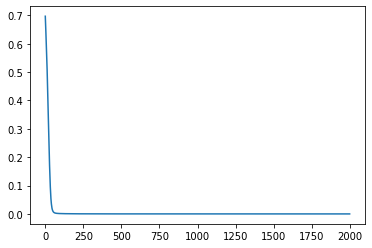

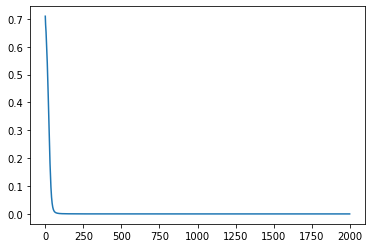

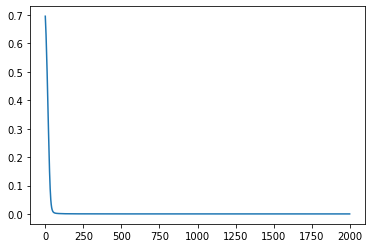

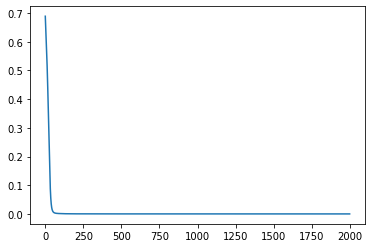

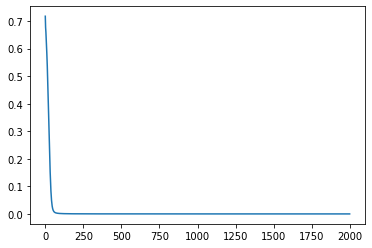

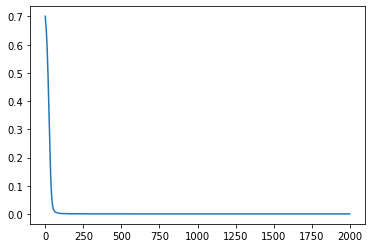

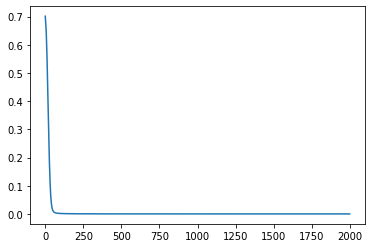

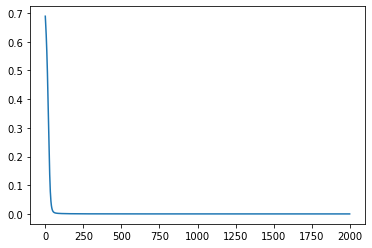

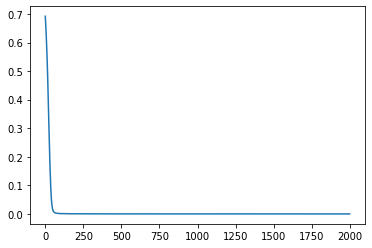

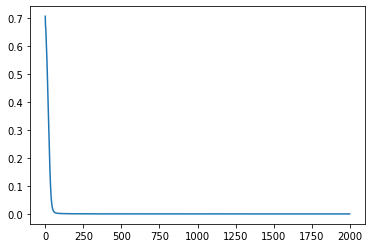

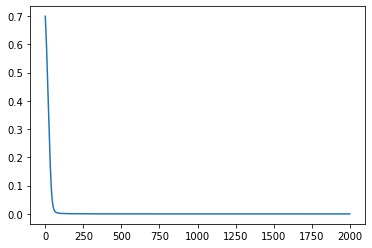

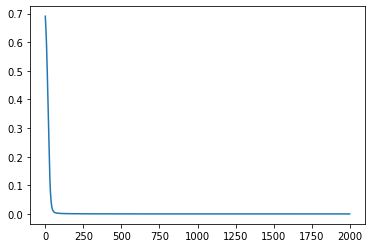

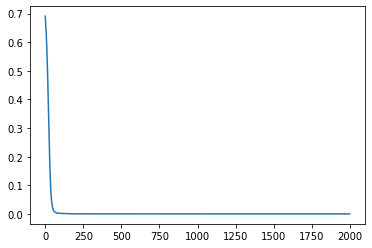

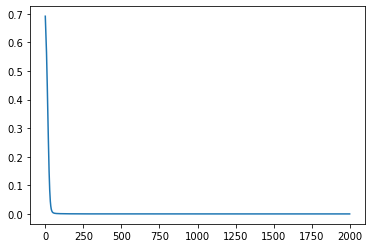

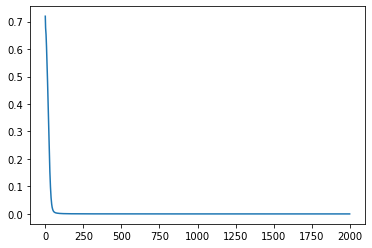

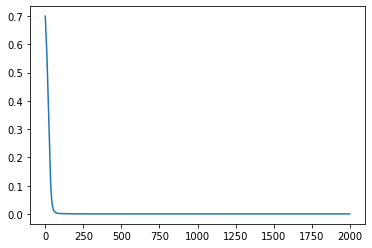

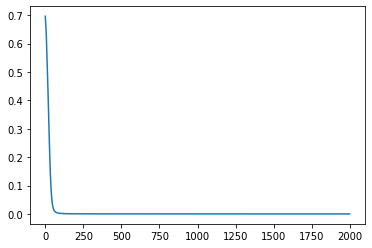

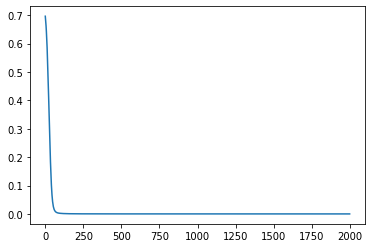

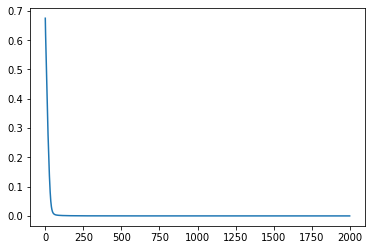

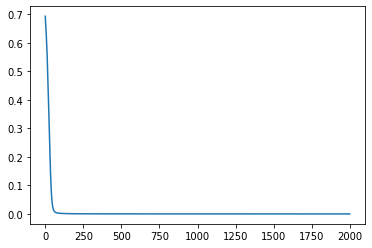

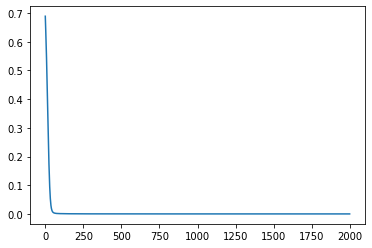

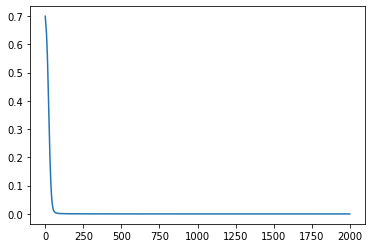

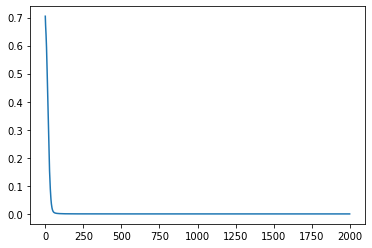

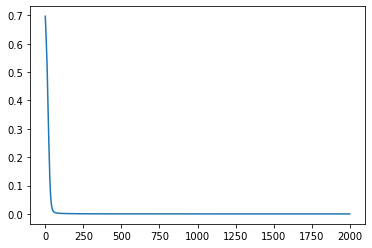

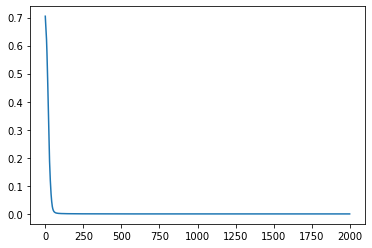

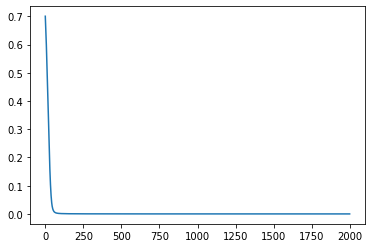

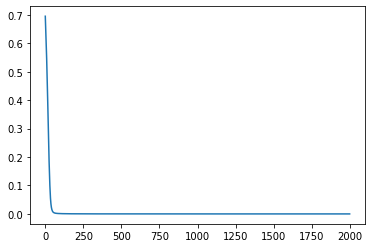

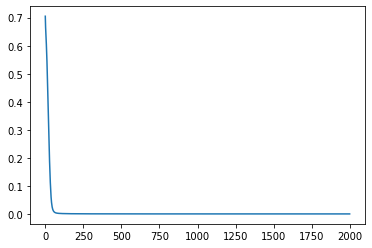

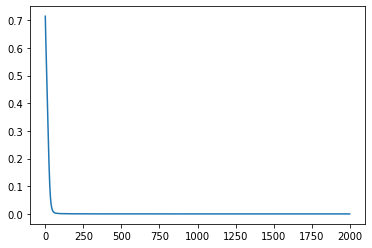

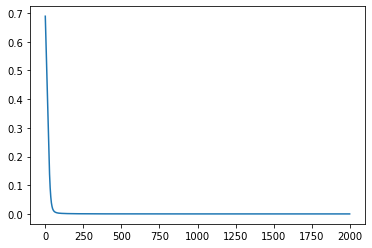

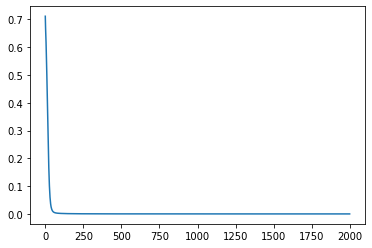

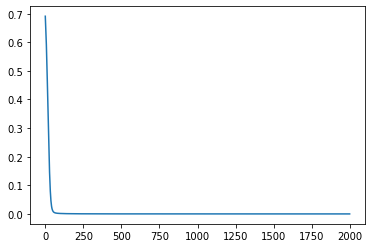

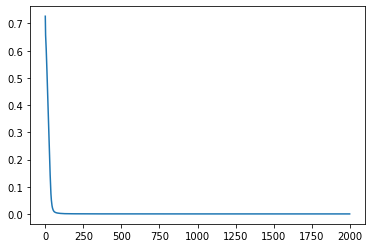

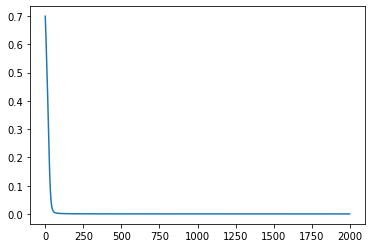

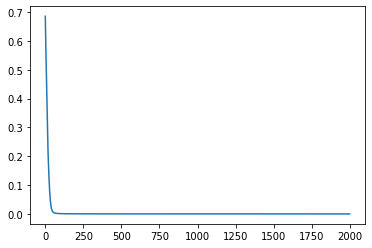

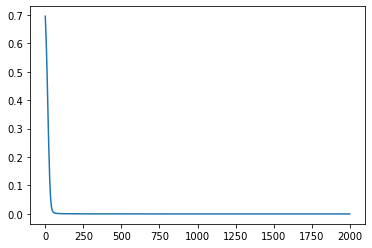

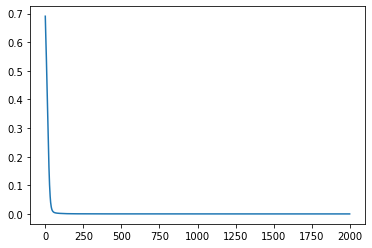

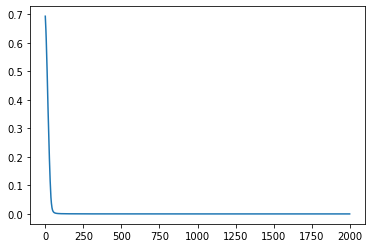

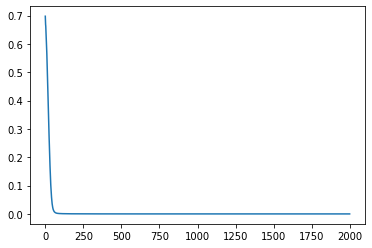

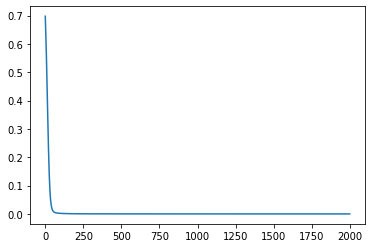

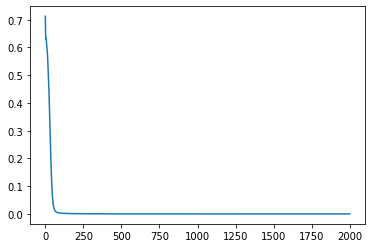

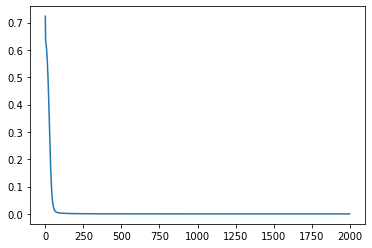

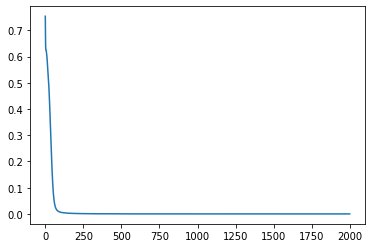

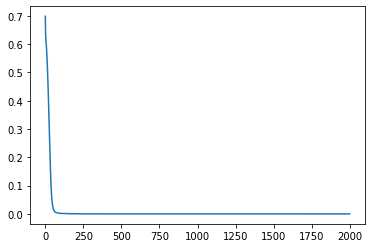

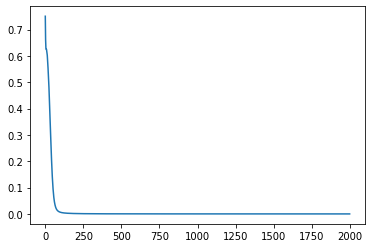

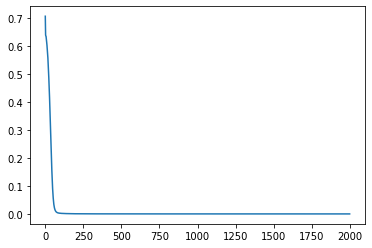

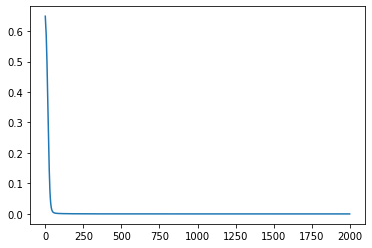

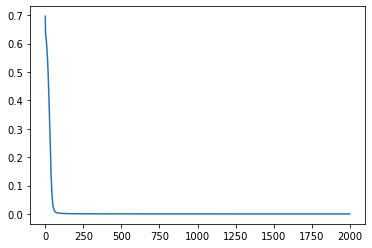

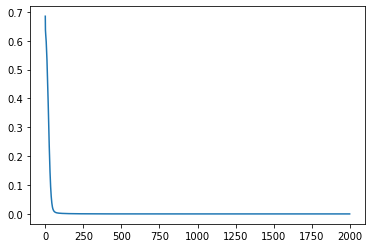

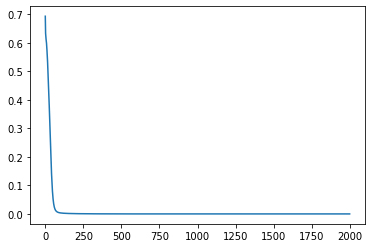

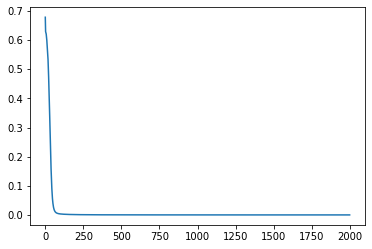

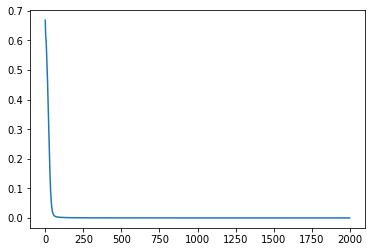

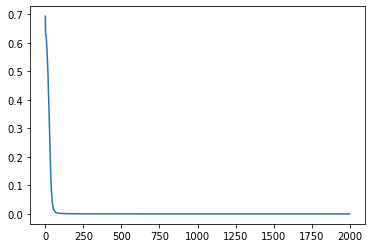

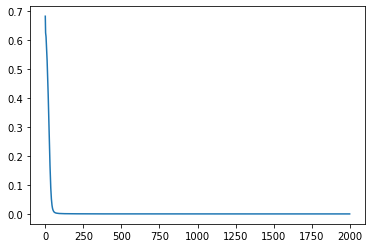

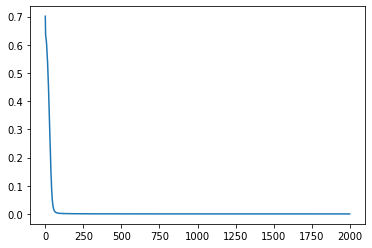

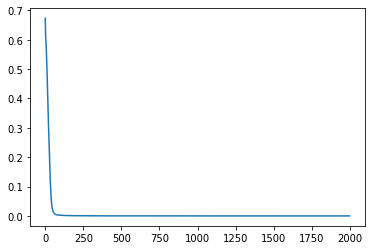

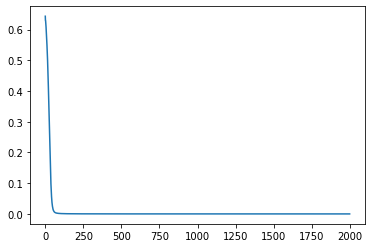

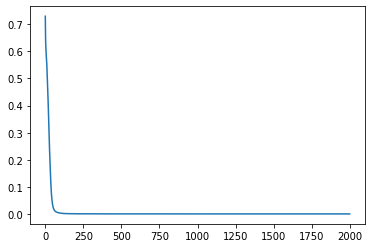

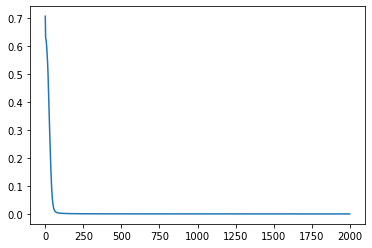

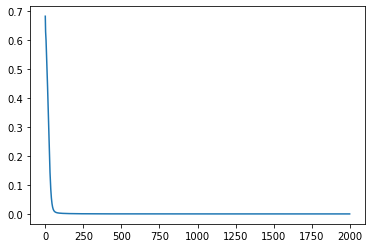

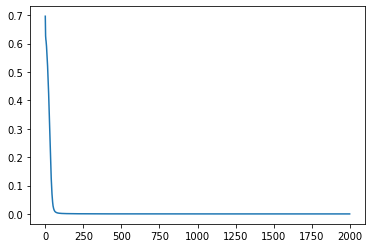

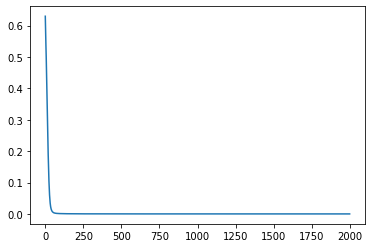

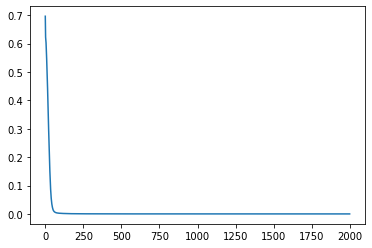

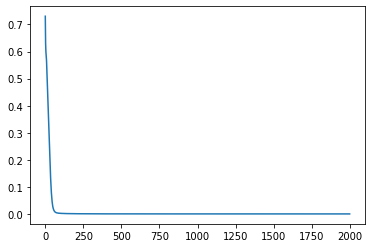

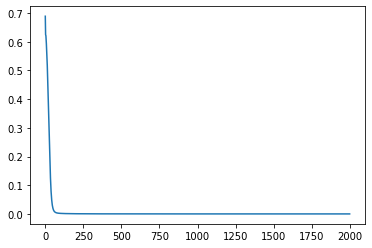

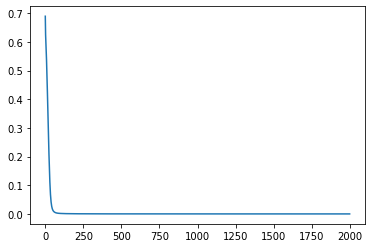

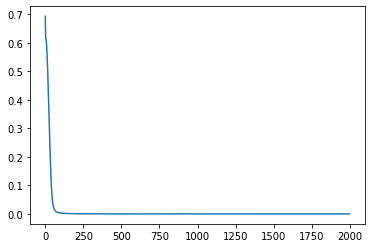

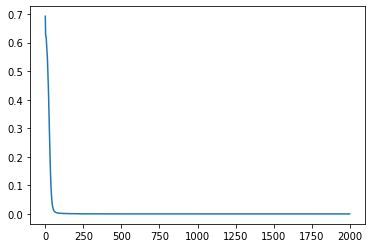

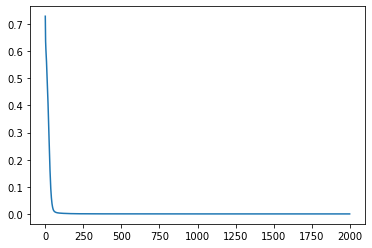

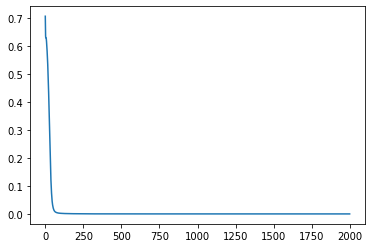

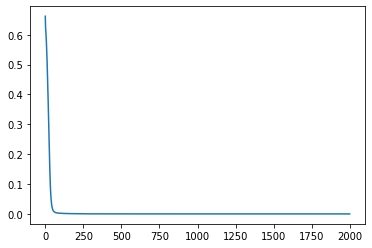

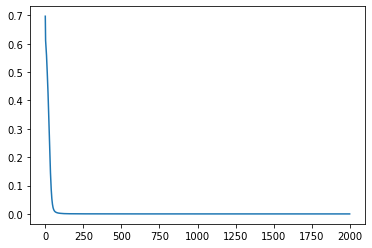

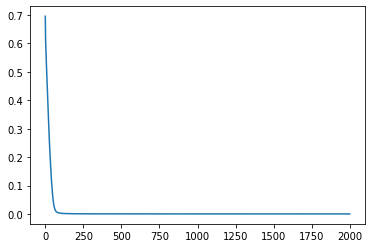

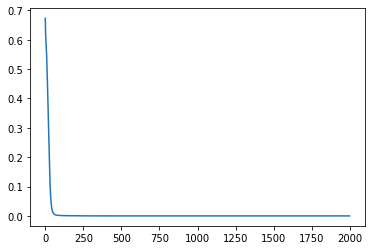

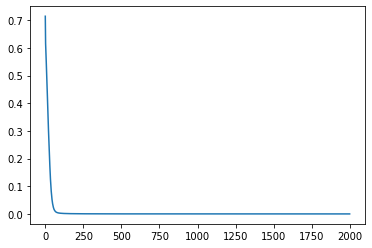

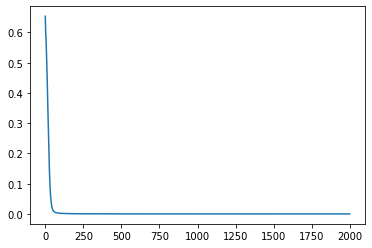

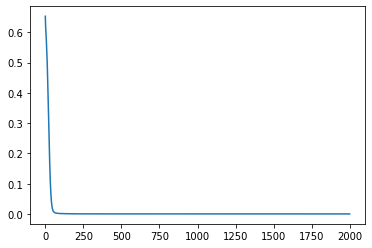

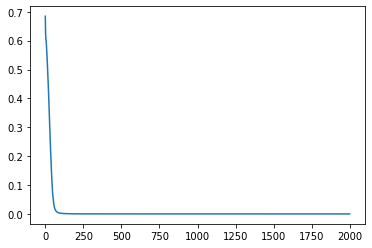

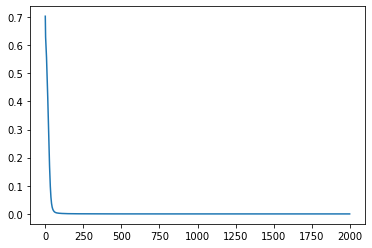

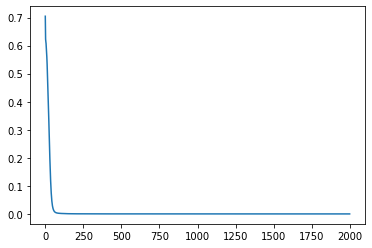

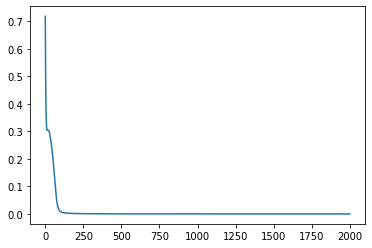

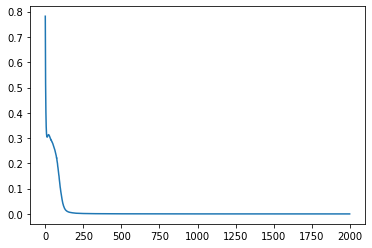

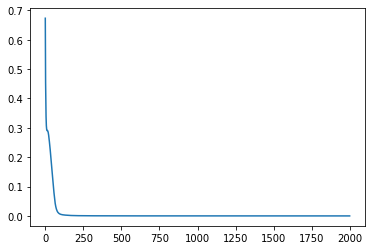

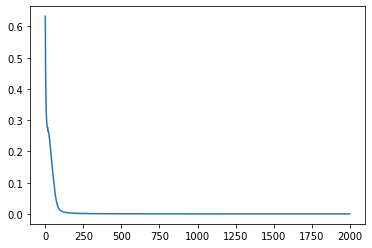

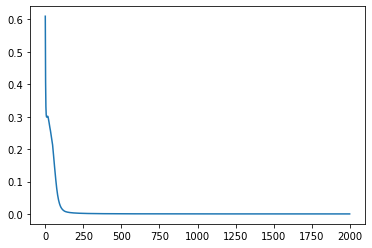

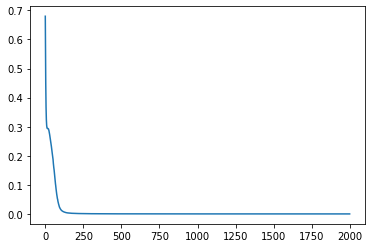

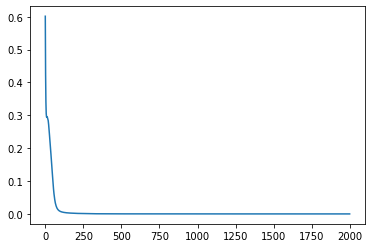

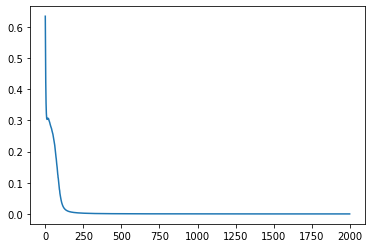

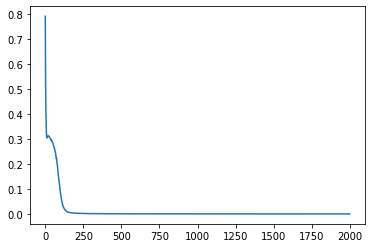

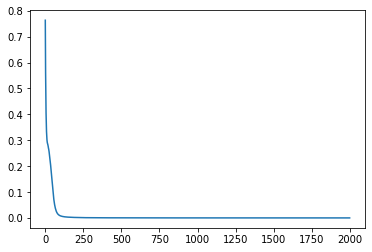

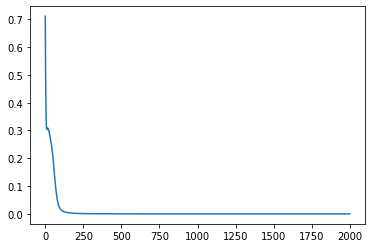

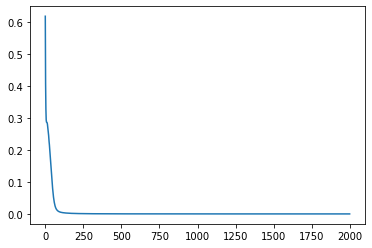

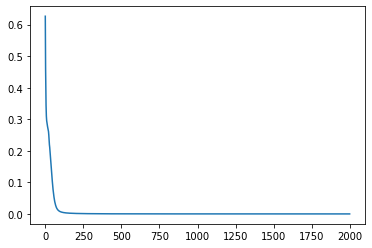

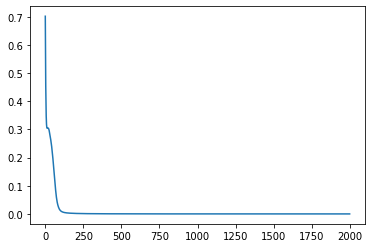

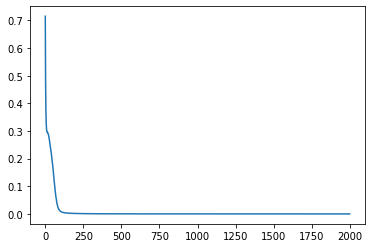

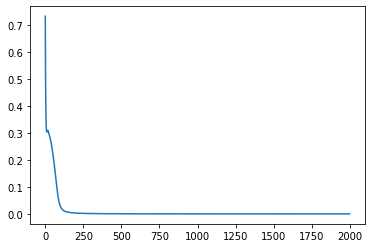

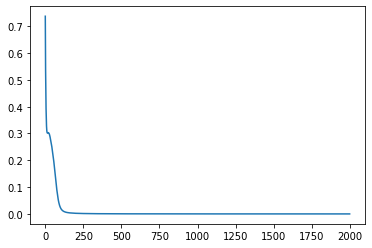

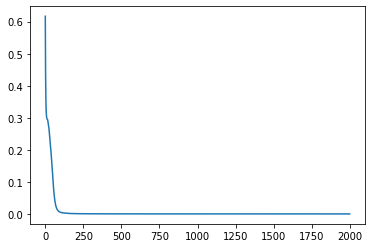

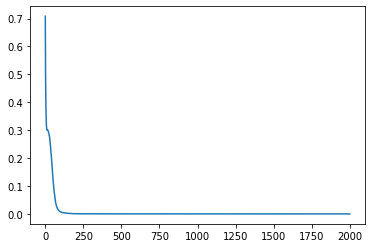

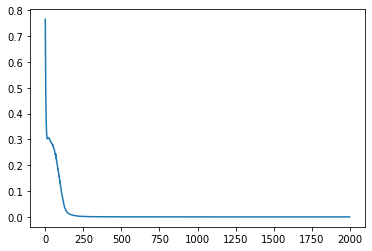

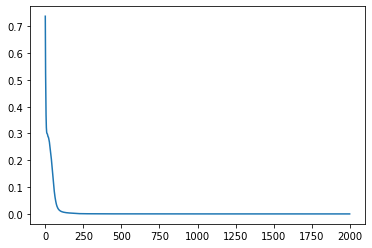

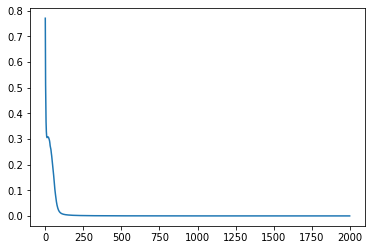

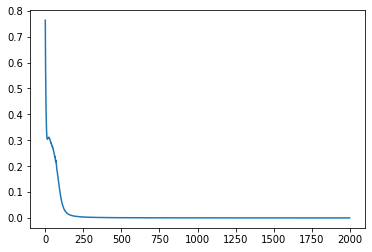

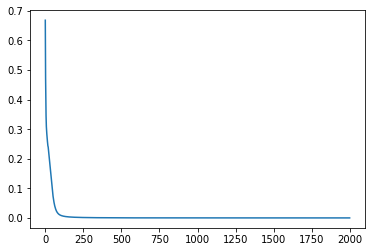

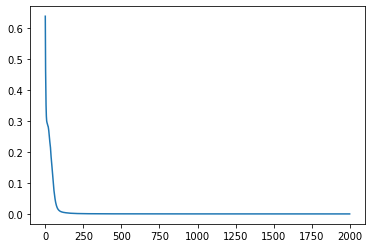

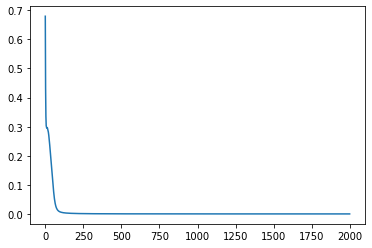

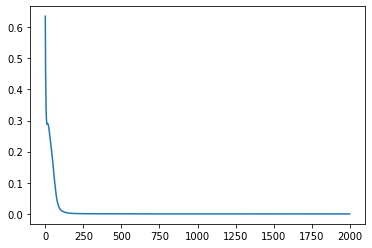

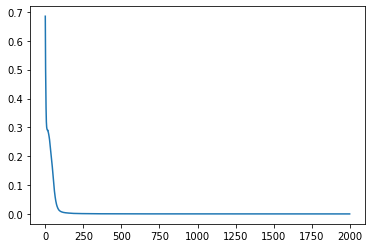

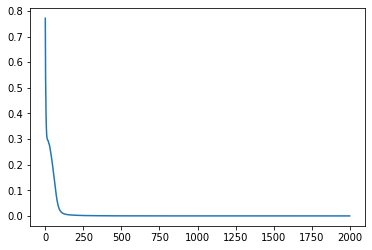

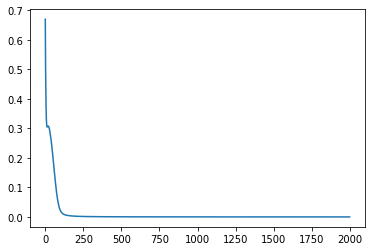

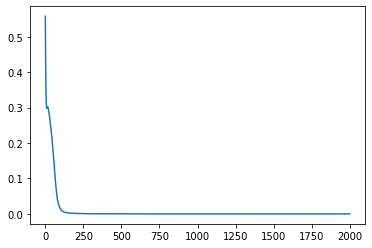

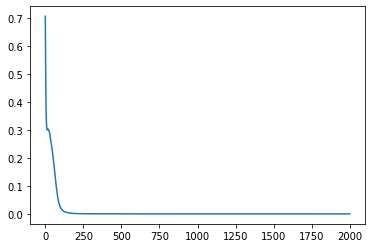

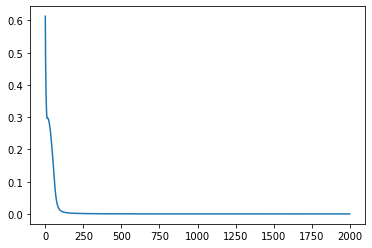

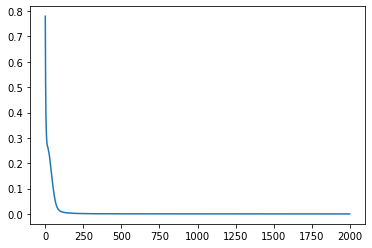

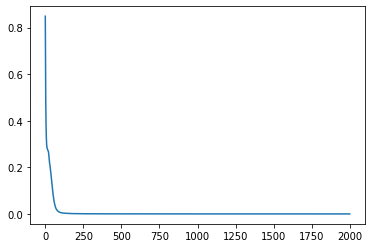

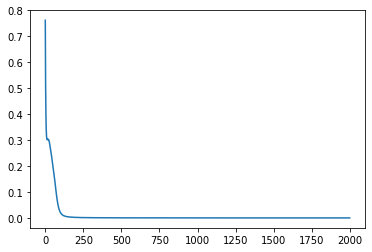

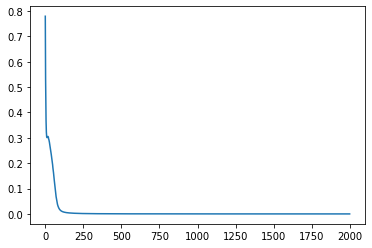

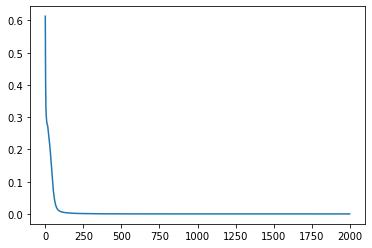

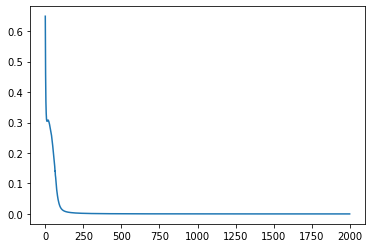

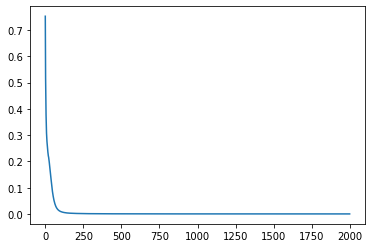

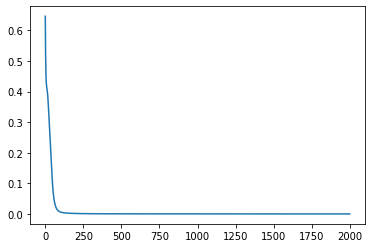

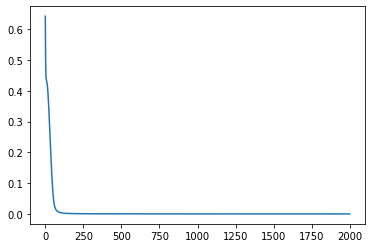

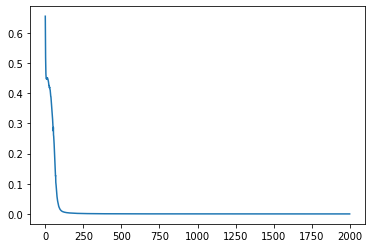

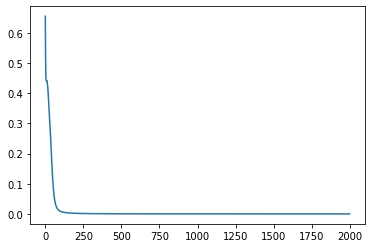

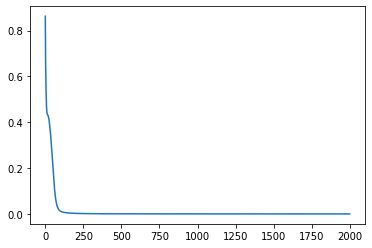

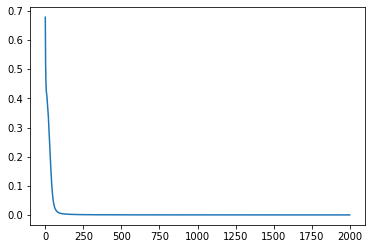

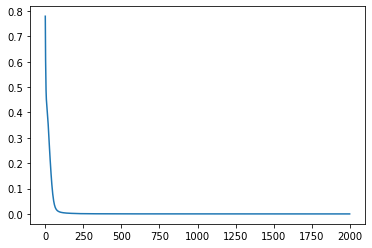

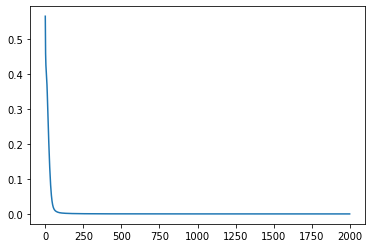

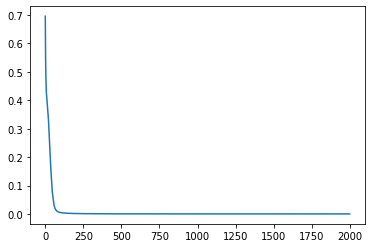

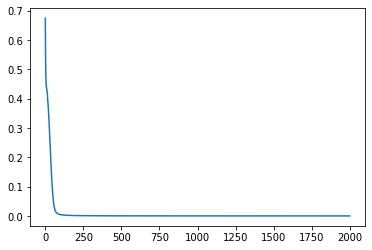

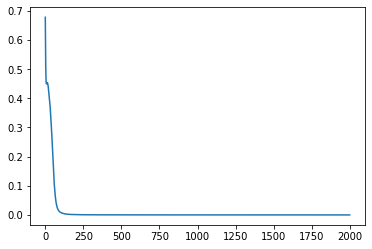

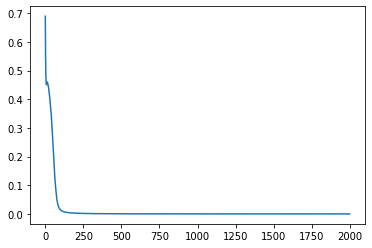

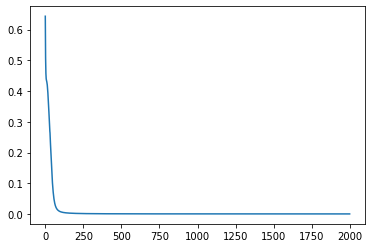

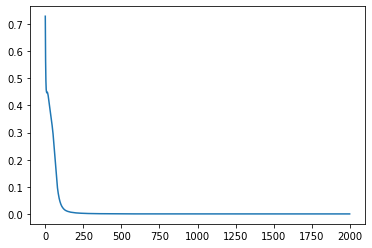

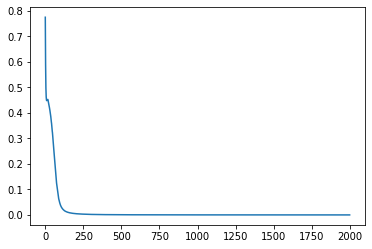

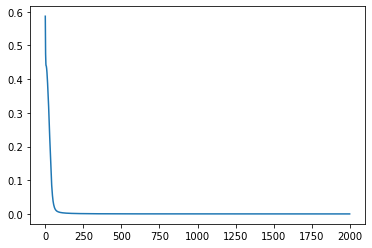

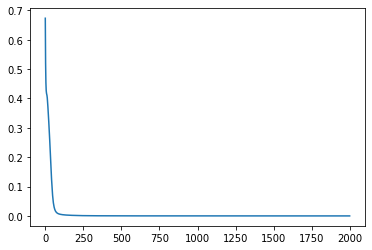

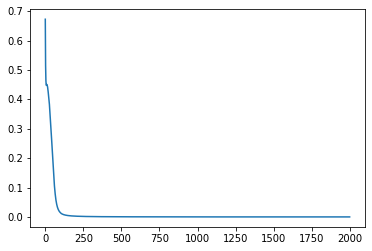

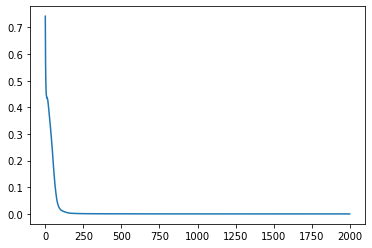

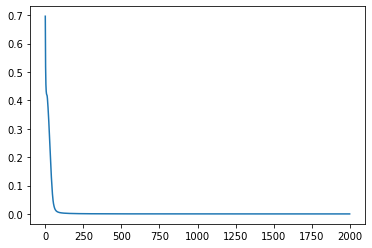

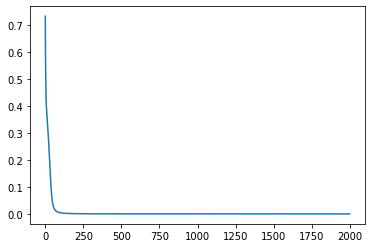

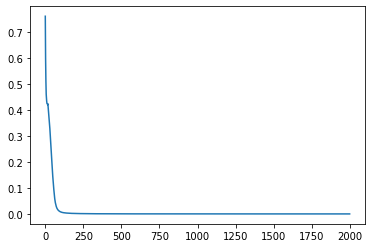

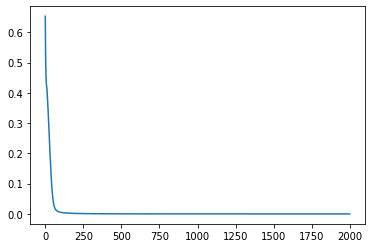

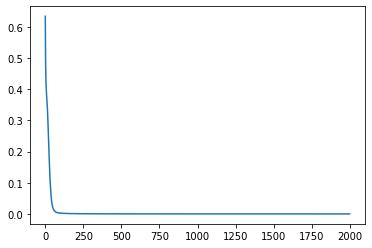

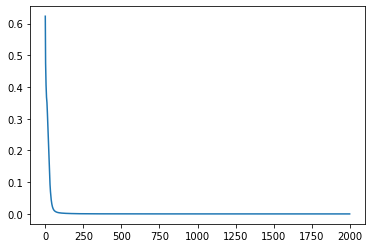

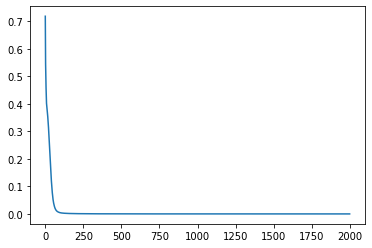

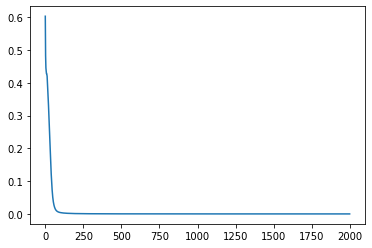

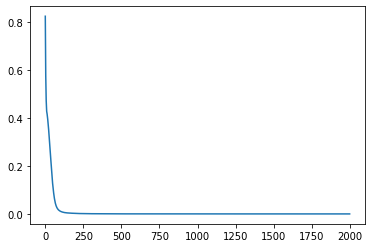

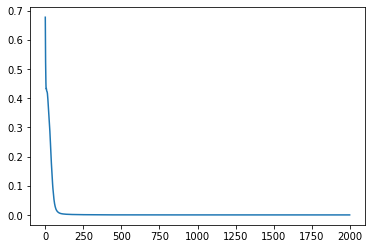

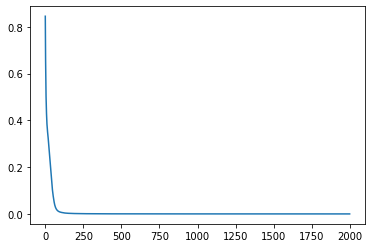

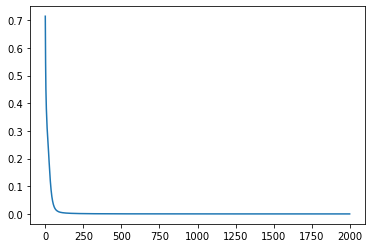

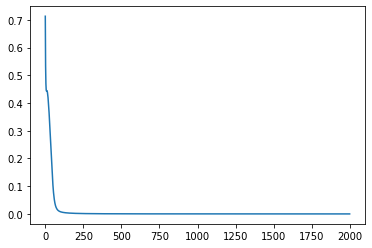

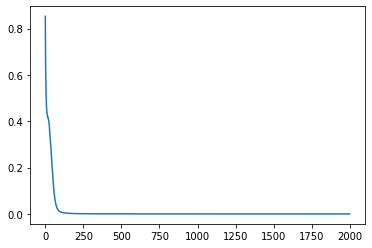

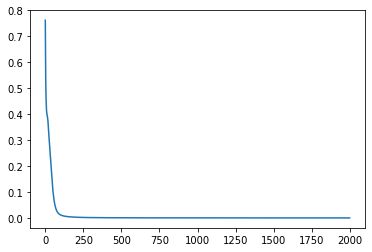

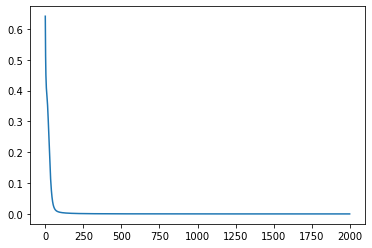

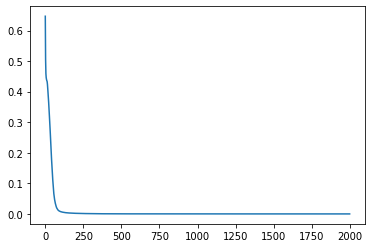

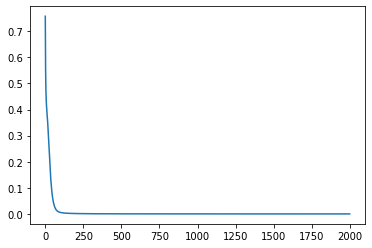

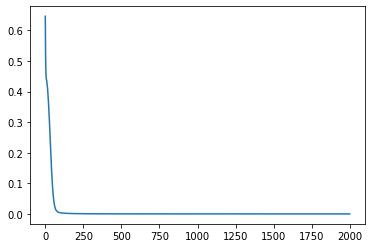

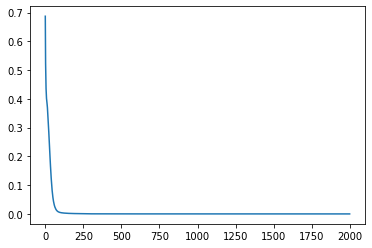

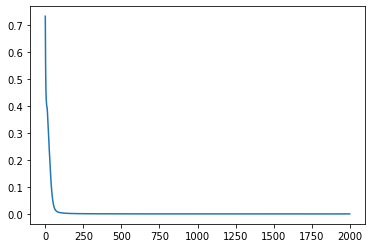

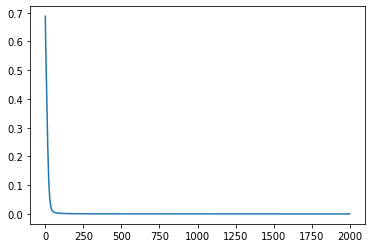

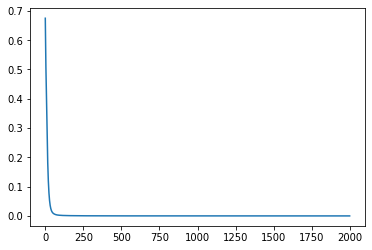

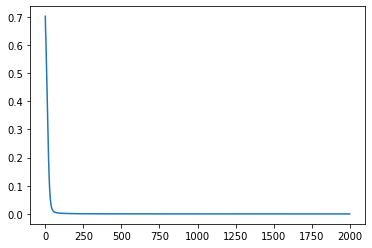

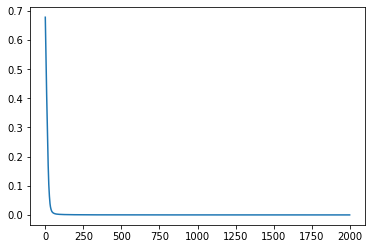

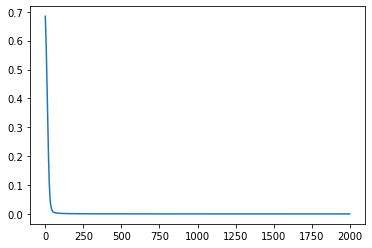

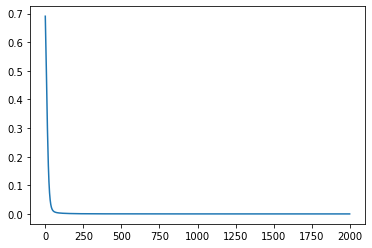

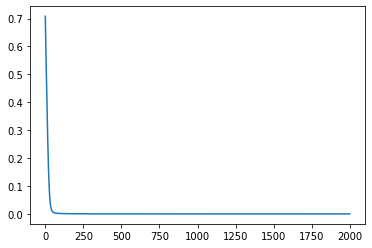

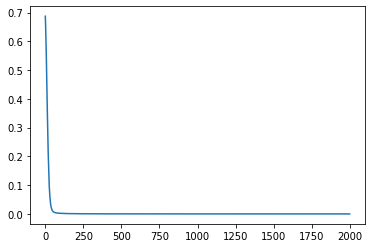

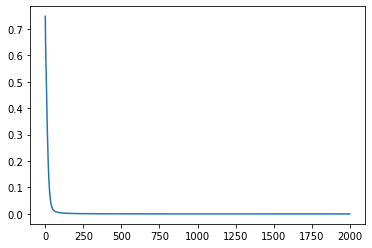

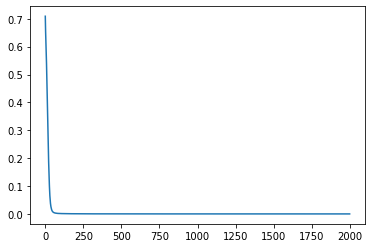

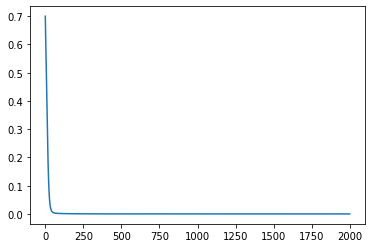

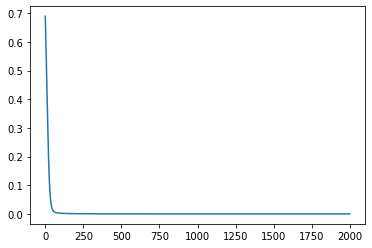

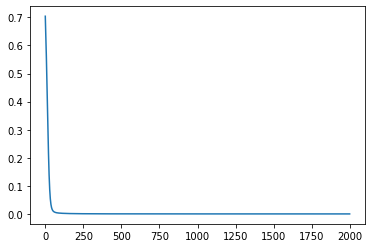

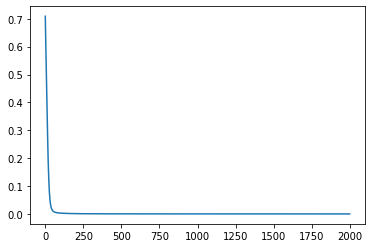

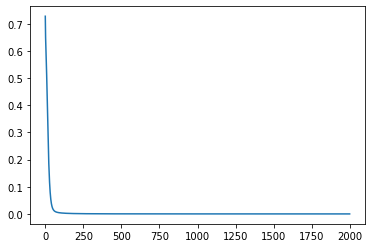

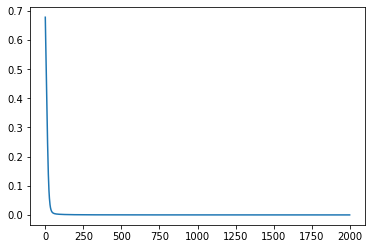

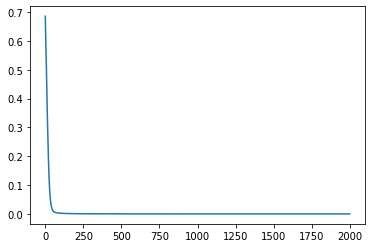

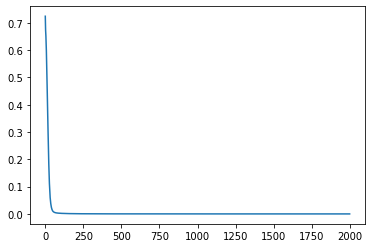

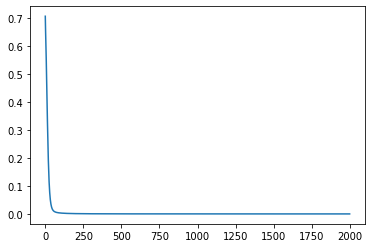

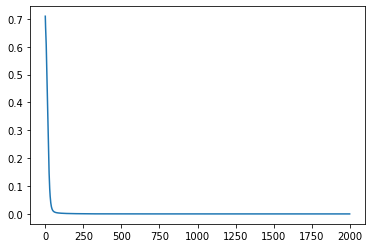

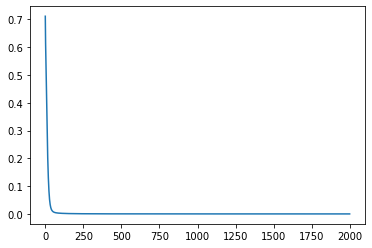

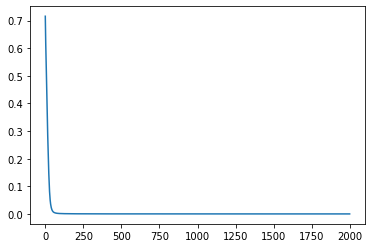

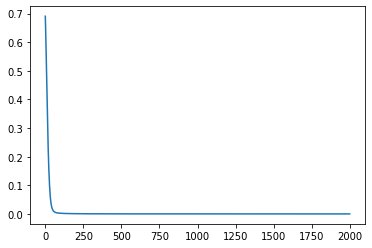

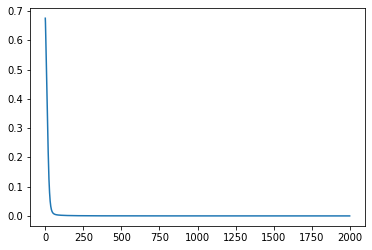

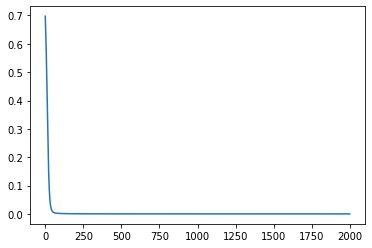

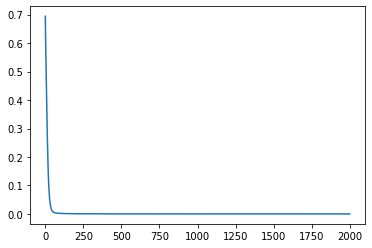

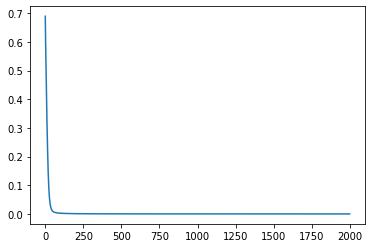

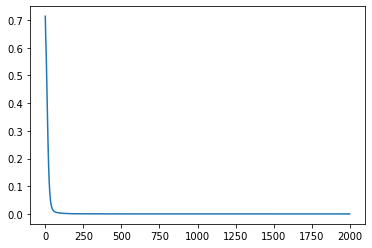

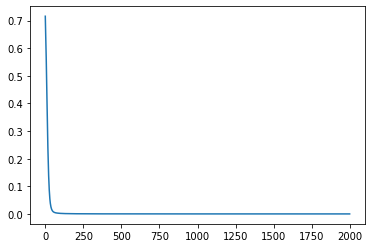

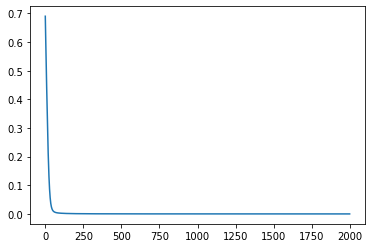

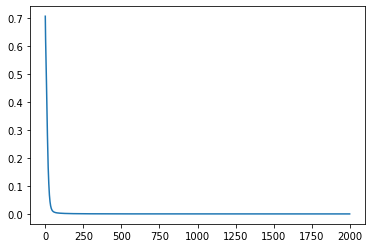

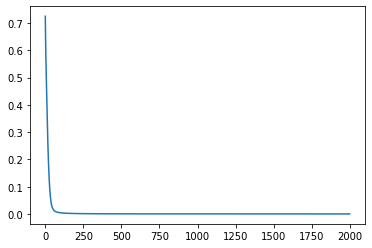

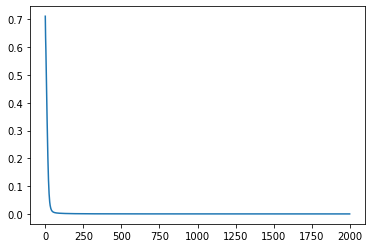

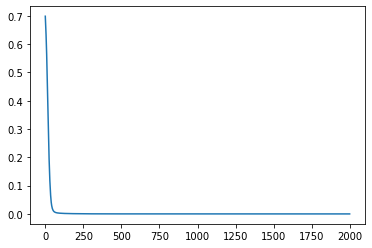

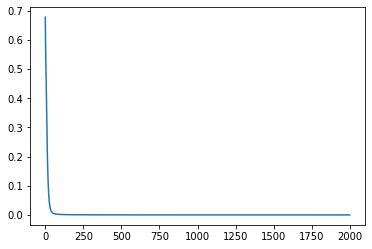

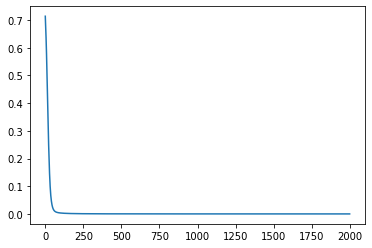

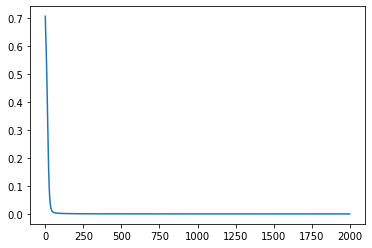

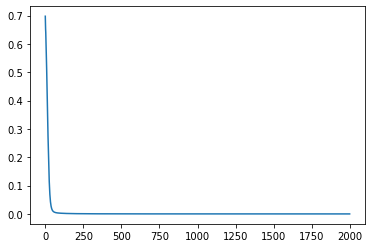

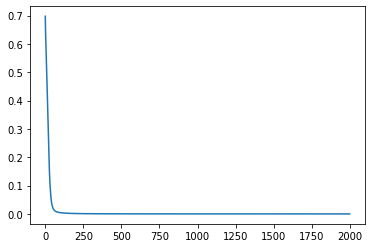

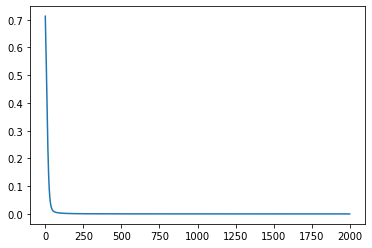

<Figure size 432x288 with 0 Axes>

time: 2h 19min 53s (started: 2021-11-30 15:00:51 +00:00)


In [ ]:
combinations = [
    [10, 10],
    [5, 10], 
    [1, 10], 
    [1, 5], 
    [1, 1]
]

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'ROC_VALUES', 'PRC_VALUES',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME'
]

load_from_saved = False
test_rounds=20

for comb in combinations:
  n_pos = comb[0]
  n_neg = comb[1]
  results = pd.DataFrame(columns=cols)
  print(f"\nRUNNING {n_pos}+/{n_neg}-")

  for task in test_dfs.keys():
    running_roc = []
    running_prc = []

    for round in range(test_rounds):
      print("ROUND ", round)
      # TRAIN TEST SPLIT
      df = test_dfs[task]
      support_neg = df[df['y'] == 0].sample(n_neg)
      support_pos = df[df['y'] == 1].sample(n_pos)
      train_data = pd.concat([support_neg, support_pos])
      test_data = df.drop(train_data.index)
      train_data = train_data.sample(frac=1)
      test_data = test_data.sample(frac=1)
      train_X, train_y = list(train_data['mol'].to_numpy()), train_data['y'].to_numpy(dtype=np.int16)
      test_X, test_y = list(test_data['mol'].to_numpy()), test_data['y'].to_numpy(dtype=np.int16)

      encoder, losses, train_info = train(train_X, train_y, episodes, lr)

      if with_bonds:
        torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}_bonds.pt")
      else:
        torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt")
      loss_plot = plt.plot(losses)[0]
      loss_plot.figure.savefig(f"{drive_path}/{method_dir}/loss_plots/{dataset}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      targets, preds, roc, prc = test(encoder, test_X, test_y, task, test_rounds, n_pos, n_neg)

      running_roc.append(roc)
      running_prc.append(prc)

    # running_roc.pop(0) # remove the added 0
    # print(running_roc)
    # running_prc.pop(0) # remove the added 0 
    # median_index = running_roc.index(statistics.median(running_roc))
    # if median_index == test_rounds:
    #   median_index = median_index - 1
    # # chart_preds = running_preds[median_index]
    # chart_actuals = running_actuals[median_index].detach().cpu()
    # chart_targets = running_targets[median_index]

    # c_auc = roc_auc_score(chart_targets, chart_preds)
    # c_fpr, c_tpr, _ = roc_curve(chart_targets, chart_preds)
    # plt.plot(c_fpr, c_tpr, marker='.', label = 'AUC = %0.2f' % c_auc)
    # plt.plot([0, 1], [0, 1],'r--', label='No Skill')
    # plt.plot([0, 0, 1], [0, 1, 1], 'g--', label='Perfect Classifier')
    # plt.title('Receiver Operating Characteristic')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend(loc = 'best')
    # plt.savefig(f"{drive_path}/{method_dir}/graphs/roc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
    # plt.figure().clear()

    # # prc_graph = PrecisionRecallDisplay.from_predictions(chart_targets, chart_preds)
    # c_precision, c_recall, _ = precision_recall_curve(chart_targets, chart_preds)
    # plt.title('Precision Recall Curve')
    # # plt.plot([0, 1], [0, 0], 'r--', label='No Skill')
    # no_skill = len(chart_targets[chart_targets==1]) / len(chart_targets)
    # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plt.plot([0, 1, 1], [1, 1, 0], 'g--', label='Perfect Classifier')
    # plt.plot(c_recall, c_precision, marker='.', label = 'AUC = %0.2f' % auc(c_recall, c_precision))
    # plt.legend(loc = 'best')
    # plt.savefig(f"{drive_path}/{method_dir}/graphs/prc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
    # plt.figure().clear()

    # cm = ConfusionMatrixDisplay.from_predictions(chart_targets, chart_actuals)
    # plt.title('Confusion Matrix')
    # plt.savefig(f"{drive_path}/{method_dir}/graphs/cm_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
    # plt.figure().clear()

    # round_acc = f"{statistics.mean(running_acc):.3f} \u00B1 {statistics.stdev(running_acc):.3f}"
    round_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
    round_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"

    dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
    cpu = cpu.split('\n')[0].split('\t: ')[-1]
    cpu_count = psutil.cpu_count()
    cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
    gpu = get_cmd_output("nvidia-smi -L")
    general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
    gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal

    rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                        dataset, {method_dir}, f"{n_pos}+/{n_neg}-",
                        task, 0, round_roc, round_prc, 
                        running_roc, running_prc,
                        train_info["train_roc"], train_info["train_prc"], train_info["episodes"], train_info["duration"]
          ]], columns=cols)

    results = pd.concat([results, rec])

  results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)